## AB Testing

### Preprocessing and EDA

In [26]:
#Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

In [27]:
#Read the dataset and display the top 5 rows
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [28]:
#Dataset dimension
df.shape 

(294478, 5)

In [29]:
#Find the number of unique users in the dataset
unique_user = df['user_id'].nunique()
unique_user

290584

In [30]:
#Determine the proportion of users converted
df.query('converted == 1').user_id.size / df.user_id.size

0.11965919355605512

In [31]:
#Find the number of times old_page and control do not line up
not_line_up_1=df.query('landing_page == "old_page" and group == "treatment"').user_id.size 
not_line_up_1

1965

In [32]:
#Find the number of times new_page and treatment do not line up
not_line_up_2=df.query('landing_page == "new_page" and group == "control"').user_id.nunique() 
not_line_up_2

1928

In [33]:
not_line_up_1 + not_line_up_2

3893

In [34]:
#Check if any of the rows have missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [35]:
'''Store only the aligned data in dataframe df2 i.e discard the rows where treatment is not aligned with new_page 
or control is not aligned with old_page'''
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [36]:
#Double check if all of the incorrect rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [37]:
df2['converted'].value_counts()

0    255832
1     34753
Name: converted, dtype: int64

In [38]:
#Find the number of unique user_ids in df2
df2['user_id'].nunique()

290584

In [39]:
#Check for duplicate values
df2['user_id'].duplicated().sum()

1

In [40]:
#Display the row information for the duplicated user_id
#random way of picking one of the duplicated users
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [41]:
#Remove one of the duplicated rows
df2.drop_duplicates(keep='first')
df2.duplicated().sum()

0

In [42]:
#Find the probability of an individual converting regardless of the page they receive.
r1 = round(df2.converted.mean(),4)
print(r1)

0.1196


In [43]:
#If an individual was in the control group, find the probability they converted.
control=df2.query("group=='control'").converted.mean()
r2 = round(control,4)
print(r2)

0.1204


In [44]:
#If an individual was in the treatment group, find the probability they converted.
treat=df2.query("group=='treatment'").converted.mean()
r3 = round(treat,4)
print(r3)

0.1188


In [45]:
#Find the probability that an individual received the new page.
new_page = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
total = float(df2.shape[0])
r4 = round(new_page/total,4)
print(r4)

0.5001


In [46]:
#Find the probability given that an individual was in new landing page
old_page = float(df2.query("landing_page == 'new_page' and converted == 1 ")['user_id'].nunique())
total = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
                  
r5 = round(old_page / total,4)
print(r5)

0.1188


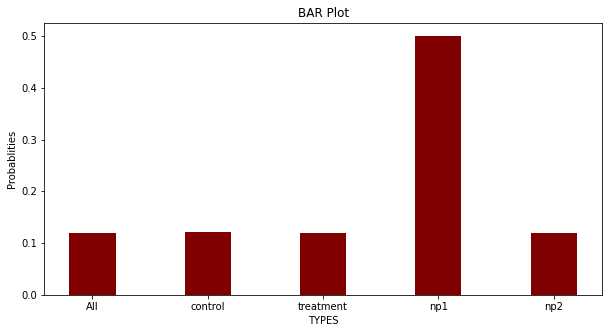

In [47]:
# creating the bar plot

data = {'All':r1, 'control':r2, 'treatment':r3,
        'np1':r4,"np2":r5}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 

plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("TYPES")
plt.ylabel("Probablities")
plt.title("BAR Plot")
plt.show()

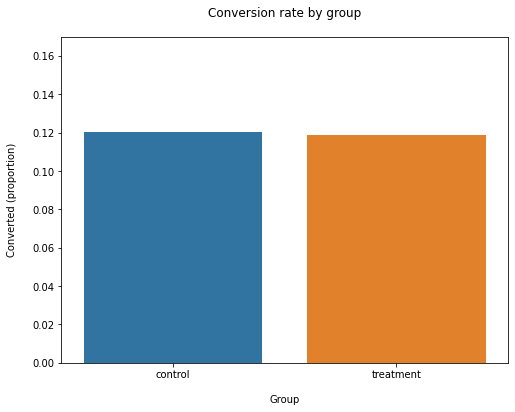

In [48]:
#Plot conversion rates of the control and treatment groups
plt.figure(figsize=(8,6))

sns.barplot(x=df2['group'], y=df2['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

About 12.04% of the control group is likely to be converted and about 11.88% of the treatment group is likely to be converted.Thus we do not have sufficient evidence to prove that the new version of the web page leads to better conversion rate.Also the expected conversion rate is higher than the conversion rate of the control group actually obtained.

### AB TEST
* H_O : p(new)-p(old)<=0  old has better conversion 
* H_1 : p(new)-p(old)>0   new has better conversion 


In [49]:
# Convert rate for p(new) under null
p_new = df2.converted.mean()
p_new


0.11959667567149027

In [50]:
# Convert rate for p(old) under null
p_old = df2.converted.mean()
p_old

0.11959667567149027

Here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

In [51]:
# Unique Number of accessing new page 
N_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
N_new

145310

In [52]:
# Unique Number of accessing old page 
N_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
N_old

145274

 Simulate n(new) transactions with a convert rate of p(new) under the null. Store these n(new) 1's and 0's in new_page_converted.

In [53]:
new_page_converted = np.random.choice([0,1] , N_new , p=(p_new,1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 0])

Simulate n(old) transactions with a convert rate of p(old) under the null.Store these n(old) 1's and 0's in old_page_converted.

In [54]:
old_page_converted = np.random.choice([0,1] , N_old , p=(p_old,1-p_old))
old_page_converted 

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
new_page_converted.mean() , old_page_converted.mean()

(0.8806069781845709, 0.881245095474758)

Find p(new) -p(old) for the simulated values 

In [56]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0006381172901871457

In [57]:
p_diffs=[]
new_convert=np.random.binomial(N_new, p_new, 10000)/N_new
old_convert=np.random.binomial(N_old, p_old, 10000)/N_old
p_diffs=new_convert-old_convert

Create sampling distribution for difference in completion rates with boostrapping

Plot a histogram of the p_diffs

(array([   7.,   92.,  460., 1580., 2696., 2819., 1660.,  562.,  106.,
          18.]),
 array([-4.60644589e-03, -3.69176663e-03, -2.77708737e-03, -1.86240811e-03,
        -9.47728848e-04, -3.30495864e-05,  8.81629675e-04,  1.79630894e-03,
         2.71098820e-03,  3.62566746e-03,  4.54034672e-03]),
 <a list of 10 Patch objects>)

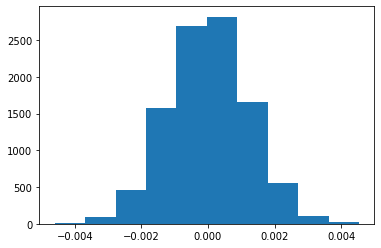

In [58]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv

In [59]:
converted_new = df2.query('converted == 1 and landing_page== "new_page"')['user_id'].nunique()
actual_new = float(converted_new) / float(N_new)

# number of landing old page and converted  / number of landing old page
converted_old = df2.query('converted == 1 and landing_page== "old_page"')['user_id'].nunique()
actual_old = float(converted_old) / float(N_old)

#observed difference in converted rate
obs_diff = actual_diff = actual_new - actual_old
obs_diff

-0.0015782389853555567

In [60]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

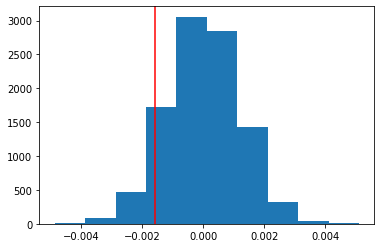

In [61]:
#Plot Null distribution
plt.hist(null_vals)
#Plot vertical line for observed statistic
plt.axvline(x=obs_diff,color ='red')

In [62]:
(null_vals > obs_diff).mean()

0.9085

In [63]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page== "old_page"').user_id.nunique()
convert_new = converted_old = df2.query('converted == 1 and landing_page== "new_page"').user_id.nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

convert_old,convert_new , n_old , n_new

(17489, 17264, 145274, 145310)

In [64]:
# compute the sm.stats.proportions_ztest using the alternative
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

#  it's a one tail test so a z-score past 1.96 will be significant.

(-1.3109241984234394, 0.9050583127590245)

The value 0.905 we call it P-value, which suggests if there is a significant difference between 2 groups for a hypothesis.
In this case, the new page doesn't have better conversion rates than the old page because the value 0.9 is much higher than the alpha, 0.05(Type I error rate). 
We fail to reject the null hypothesis. Therefore, this shows that, with a type I error rate of 0.05, the old page has higher probability of convert rate than new page.


### LOGISTIC REGRESSION

 Under logistic model, the hypothesis test is under : 

 H0: p_new =  p_old , H1: p_new ≠ p_old (Two sided test)

In [65]:
# create a column for the intercept
df2['intercept'] = 1
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [66]:
# create a dummy variable column for which page each user received
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [67]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [68]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Nov 2022   Pseudo R-squ.:               8.085e-06
Time:                        07:11:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

#**To study the effect based on the country a user lives in**

In [69]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [70]:
# join two dataframes on common column 'user_id'
df3 = df2.join(df_country.set_index('user_id'),on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [71]:
# create dummy variables for country
df3[['US','UK','CA']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])
df3['intercept'] = 1
log_mod = sm.Logit(df3['converted'], df3[['intercept','US','UK','ab_page']]) 
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Nov 2022   Pseudo R-squ.:               2.326e-05
Time:                        07:11:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1756
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.760      0.000      -2.007      -1.972
US            -0.0408      0.027     -1.516      0.129      -0.093       0.012
UK             0.0099      0.013      0.743      0.458      -0.016       0.036
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
==============================================================================
"""

In [72]:
# create dummy variables for country
df3['intercept'] = 1
# interaction between page and country 
df3['US_new'] = df3['US'] * df3['ab_page']
df3['UK_new'] = df3['UK'] * df3['ab_page']
log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','UK','US_new' ,'UK_new' ]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290583
Model:                          Logit   Df Residuals:                   290577
Method:                           MLE   Df Model:                            5
Date:                Fri, 11 Nov 2022   Pseudo R-squ.:               3.485e-05
Time:                        07:11:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1915
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.341      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.508      0.132      -0.047       0.006
US            -0.0176      0.038     -0.466      0.641      -0.091       0.056
UK            -0.0058      0.019     -0.307      0.759      -0.043       0.031
US_new        -0.0469      0.054     -0.871      0.384      -0.152       0.059
UK_new         0.0314      0.027      1.182      0.237      -0.021       0.084
==============================================================================
"""

### MODELLING TECHINQUES

In [73]:
#Drop the timestamp column
df2=df2.drop(['timestamp'],axis=1)
df2

,user_id,group,landing_page,converted,intercept,ab_page
0,851104,control,old_page,0,1,0
1,804228,control,old_page,0,1,0
2,661590,treatment,new_page,0,1,1
3,853541,treatment,new_page,0,1,1
4,864975,control,old_page,1,1,0
...,...,...,...,...,...,...
294473,751197,control,old_page,0,1,0
294474,945152,control,old_page,0,1,0
294475,734608,control,old_page,0,1,0
294476,697314,control,old_page,0,1,0


In [74]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df2.loc[:, df2.columns != 'converted'],\
                                                    df2['converted'], test_size=0.2)

In [75]:
#label encoding the categorical values
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
X_train['group'] = lb.fit_transform(X_train['group'])
X_test['group'] = lb.transform(X_test['group'])

X_train['landing_page'] = lb.fit_transform(X_train['landing_page'])
X_test['landing_page'] = lb.transform(X_test['landing_page'])


In [76]:
X_train

,user_id,group,landing_page,intercept,ab_page
205977,652744,0,1,1,0
75560,635888,1,0,1,1
131310,787858,1,0,1,1
110016,798417,1,0,1,1
155554,808823,1,0,1,1
...,...,...,...,...,...
63684,638691,0,1,1,0
183169,945387,1,0,1,1
280368,689742,1,0,1,1
144412,912693,0,1,1,0


In [77]:
#Function for printing the evaluation scores related to a regression problem
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

**MULTIPLE LINEAR REGRESSION**

In [78]:
import statsmodels.api as sm

X_train_refined = X_train.drop(columns=['user_id'], axis=1) #user_id not significant hence drop
linear_regression = sm.OLS(y_train, X_train_refined)
linear_regression = linear_regression.fit()

In [79]:
X_test_refined = X_test.drop(columns=['user_id'], axis=1)
y_preds = linear_regression.predict(X_test_refined)

In [80]:
calculate_metrics(y_test, y_preds)

RMSE Score: 0.3234314757346263
R2_Squared: -3.835129675389126e-05
MAE Score: 0.21016787608036544


In [81]:
print(linear_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.409
Date:                Fri, 11 Nov 2022   Prob (F-statistic):              0.244
Time:                        07:11:56   Log-Likelihood:                -68403.
No. Observations:              232468   AIC:                         1.368e+05
Df Residuals:                  232465   BIC:                         1.368e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
group        -7.681e+09   3.26e+10     -0.235   

In [82]:
#computing the p-value for each column
pd.DataFrame(linear_regression.pvalues)\
    .reset_index()\
    .rename(columns={'index':'Terms', 0:'p_value'})\
    .sort_values('p_value')

,Terms,p_value
2,intercept,0.813881
3,ab_page,0.813881
1,landing_page,0.813881
0,group,0.813881


**DECISION TREES**

In [83]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf =4, random_state=7)
dtree.fit(X_train_refined, y_train)
y_preds = dtree.predict(X_test_refined)

calculate_metrics(y_test, y_preds)

RMSE Score: 0.3234314383958615
R2_Squared: -3.8120396564256254e-05
MAE Score: 0.21006961786083822
